In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from IPython import display

from dedalus import public as de
from dedalus.extras import flow_tools

import logging
logger = logging.getLogger(__name__)

In [2]:
#Aspect ratio 2
#Lx, Ly = (1.8, 5.)
Lx, Ly = (18, 29)
nx, ny = (300, 450)

# Create bases and domain
x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Chebyshev('y', ny, interval=(0, Ly), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

In [3]:
def grow_fun(A,B):
    F = (A.data-1e-3)*(1-B.data)
    #F[F<0] = 0
    F[A.data < 1e-3] = 0
    return F


def grow_operator(field1,field2):
    # Return GeneralFunction instance that applies erf_func in grid space
    return de.operators.GeneralFunction(
        field1.domain,
        layout = 'g',
        func = grow_fun,
        args = (field1,field2,)
    )

de.operators.parseables['grow'] = grow_operator

In [4]:
params = np.load('../1D_dynamics/Parameters.npz')
Diff = params['Diff'].flat[0]
K =  params['K'].flat[0]
g = params['g'].flat[0]

problem = de.IVP(domain, variables=['rho1','rho2','rho1y','rho2y','rho12'])
problem.parameters['D1'] = 2*Diff
problem.parameters['D2'] = 0.5*Diff
problem.parameters['K'] = K
problem.parameters['g1'] = g
problem.parameters['g2'] = g


problem.substitutions['rho_b'] = "rho1+rho2+rho12" 
problem.substitutions["Lap(A,Ay)"] = "dx(dx(A)) + dy(Ay)"


problem.add_equation("dt(rho1)  - D1*Lap(rho1,rho1y) = g1*grow(rho1,rho_b)  - K*rho1*rho2")
problem.add_equation("dt(rho2)  - D2*Lap(rho2,rho2y) = g2*grow(rho2,rho_b)  - K*rho1*rho2")
problem.add_equation("dt(rho12)  = 2*K*rho1*rho2")
problem.add_equation("rho1y - dy(rho1)  = 0")
problem.add_equation("rho2y - dy(rho2)  = 0")

problem.add_bc("left(rho1y) = 0")
problem.add_bc("left(rho2) = 0")
problem.add_bc("right(rho2) = 0")
problem.add_bc("right(rho1) = 0")

In [5]:
ts = de.timesteppers.RK443

In [6]:
solver =  problem.build_solver(ts)

2021-09-25 13:54:23,706 pencil 0/1 INFO :: Building pencil matrix 1/150 (~1%) Elapsed: 0s, Remaining: 5s, Rate: 3.1e+01/s
2021-09-25 13:54:24,036 pencil 0/1 INFO :: Building pencil matrix 15/150 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 4.1e+01/s
2021-09-25 13:54:24,400 pencil 0/1 INFO :: Building pencil matrix 30/150 (~20%) Elapsed: 1s, Remaining: 3s, Rate: 4.1e+01/s
2021-09-25 13:54:24,780 pencil 0/1 INFO :: Building pencil matrix 45/150 (~30%) Elapsed: 1s, Remaining: 3s, Rate: 4.1e+01/s
2021-09-25 13:54:25,148 pencil 0/1 INFO :: Building pencil matrix 60/150 (~40%) Elapsed: 1s, Remaining: 2s, Rate: 4.1e+01/s
2021-09-25 13:54:25,516 pencil 0/1 INFO :: Building pencil matrix 75/150 (~50%) Elapsed: 2s, Remaining: 2s, Rate: 4.1e+01/s
2021-09-25 13:54:25,862 pencil 0/1 INFO :: Building pencil matrix 90/150 (~60%) Elapsed: 2s, Remaining: 1s, Rate: 4.1e+01/s
2021-09-25 13:54:26,230 pencil 0/1 INFO :: Building pencil matrix 105/150 (~70%) Elapsed: 3s, Remaining: 1s, Rate: 4.1e+01/s
2021-09-2

In [7]:
x = domain.grid(0)
y = domain.grid(1)
rho1 = solver.state['rho1']
rho2 = solver.state['rho2']

def r(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

def blob(x,y,x0,y0,r0,w):
    return 0.5*(1 - np.tanh((r(x,y,x0,y0)-r0)/w))

r0 = 0.75
w = 0.22

rho1['g'] = blob(x,y,Lx*0.5,6,r0 + 80*3.04/60,w) # speed is 3.04/60 mm/min
rho2['g'] = blob(x,y,Lx*0.5,15,r0,w) # slow one starts growing ~80 mins after fast one

In [8]:
solver.stop_sim_time = 420
dt = 0.18*Lx/nx

In [9]:
analysis = solver.evaluator.add_file_handler('diff_grow', sim_dt=2, max_writes=500)
analysis.add_task('rho1')
analysis.add_task('rho2')
analysis.add_task('rho12')

(0.0, 29.0)

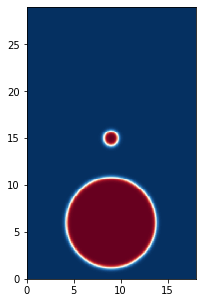

In [10]:
x = domain.grid(0,scales=1)
y = domain.grid(1,scales=1)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(10,5))
axis.set_aspect('equal')

p = axis.pcolormesh(xm, ym, (rho1['g']+rho2['g']).T, cmap='RdBu_r');
axis.set_xlim([0,Lx])
axis.set_ylim([0,Ly])

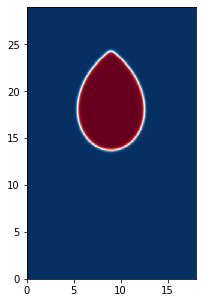

2021-09-25 21:52:56,421 __main__ 0/1 INFO :: Iteration: 38850, Time: 4.195800e+02, dt: 1.080000e-02
2021-09-25 21:53:09,400 solvers 0/1 INFO :: Simulation stop time reached.


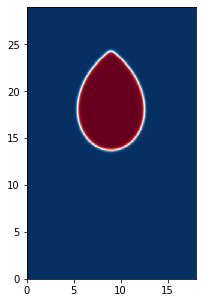

In [11]:
x = domain.grid(0,scales=1)
y = domain.grid(1,scales=1)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, rho2['g'].T, cmap='RdBu_r');
axis.set_xlim([0,Lx])
axis.set_ylim([0,Ly])
axis.set_aspect('equal')

x = domain.grid(0,scales=1.5)
y = domain.grid(1,scales=1.5)
xm, ym = np.meshgrid(x,y)

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 50 == 0:
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
    if solver.iteration % 200 == 0:
        # Update plot of scalar field
        p = axis.pcolormesh(xm, ym, rho2['g'].T, cmap='RdBu_r');
        display.clear_output()
        display.display(plt.gcf())

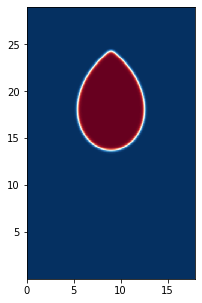

In [12]:
x = domain.grid(0,scales=1.5)
y = domain.grid(1,scales=1.5)
xm, ym = np.meshgrid(x,y)
np.shape(xm)
fig, axis = plt.subplots(figsize=(10,5))
axis.set_aspect('equal')
rhon = solver.state['rho2']
p = axis.pcolormesh(xm, ym, rho2['g'].T, cmap='RdBu_r');

In [13]:
from dedalus.tools import post
post.merge_process_files("diff_grow", cleanup=True)

2021-09-25 21:55:02,475 post 0/1 INFO :: Merging files from diff_grow


/Users/dominic/miniconda3/envs/dedalus/lib/python3.8/site-packages/dedalus/tools/post.py:230: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  joint_dset.dims.create_scale(scale, scalename)


In [3]:
f = h5py.File('diff_grow/diff_grow_s1.h5','r')
y = f['/scales/y/1.0'][:]
x = f['/scales/x/1.0'][:]
t = f['scales']['sim_time'][:]
rho1 = f['tasks']['rho1'][:]
rho2 = f['tasks']['rho2'][:]
rhom = f['tasks']['rho12'][:]

rho_t = rho1+ rho2+rhom

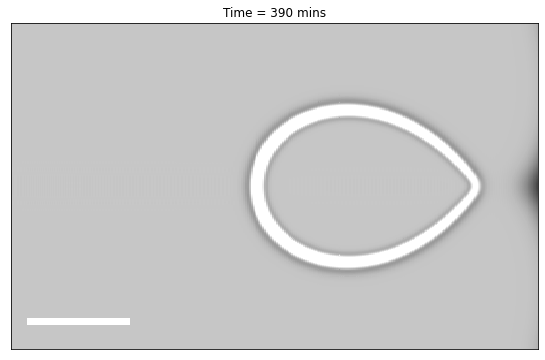

In [15]:
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(1,1,figsize=(12,6))

i = -15

p = axis.pcolormesh(ym, xm,  (rho_t[i,:,:]).T, cmap='Greys_r', vmin=0.0, vmax=1.5);
axis.set_title('Time = ' + str(int(t[i])) + ' mins')
axis.plot([1.5,6.5],[2,2],lw=7,c='w')
axis.set_ylim([0.5,Lx-0.5])
axis.set_xticks([])
axis.set_yticks([])
if i == 0:
    cbar = plt.colorbar(p)
    cbar.set_label('density (units of ' + r'$\rho_{max})$',size=12)
axis.set_xlim([0.5,Ly-1])
axis.set_aspect('equal')

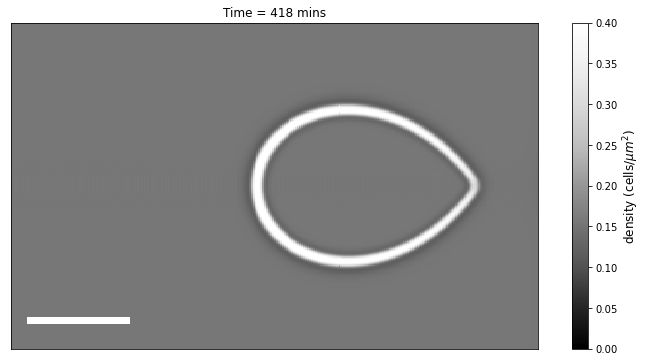

In [6]:
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(1,1,figsize=(12,6))

for i in range(np.shape(rho_t)[0]):

    p = axis.pcolormesh(ym, xm,  0.155*(rho_t[i,:,:]).T, cmap='Greys_r', vmin=0.0, vmax=0.4);
    axis.set_title('Time = ' + str(int(t[i])) + ' mins')
    axis.plot([1.5,6.5],[2,2],lw=7,c='w')
    axis.set_ylim([0.5,Lx-0.5])
    axis.set_xticks([])
    axis.set_yticks([])
    if i == 0:
        cbar = plt.colorbar(p)
        cbar.set_label('density (cells/' + r'$\mu m^2)$',size=12)
    axis.set_xlim([0.5,Ly-1])
    axis.set_aspect('equal')

    fig_save = './diff_grow/'
    fig.savefig(fig_save + 'diff_grow' + f'{i:03}' + '.png',dpi=150)

In [17]:
f = h5py.File('diff_grow/diff_grow_s1.h5','r')
t = f['scales']['sim_time'][:]
rho1 = f['tasks']['rho1'][:]
rho2 = f['tasks']['rho2'][:]
y = f['/scales/y/1.0'][:]
x = f['/scales/x/1.0'][:]
rhom = f['tasks']['rho12'][:]

rho_t = rho1 + rho2 + rhom

xm, ym = np.meshgrid(x,y)


In [20]:
i = 0
np.savez('Diff_growth_rate_init.npz',rho1=rho1[i,:,:],rho2=rho2[i,:,:],rho_t=rho_t[i,:,:],xm=xm,ym=ym)
i = -14
np.savez('Diff_growth_rate_final.npz',rho1=rho1[i,:,:],rho2=rho2[i,:,:],rho_t=rho_t[i,:,:],xm=xm,ym=ym)